<a href="https://colab.research.google.com/github/kiruthika514/.-Astronaut-Daily-Schedule-Organizer-Programming-Exercise/blob/main/Copy_of_Final_VGGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow
from tensorflow import keras
from PIL import Image
import os
import string
import pickle
from pickle import dump
from pickle import load
from tensorflow.keras.applications.vgg16 import VGG16 #to get pre-trained model Xception
from tensorflow.keras.applications.vgg16 import preprocess_input
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer #for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense#Keras to build our CNN and LSTM
from tensorflow.keras.layers import LSTM, Embedding, Dropout
#from tqdm import tqdm_notebook as tqdm #to check loop progress
#tqdm().pandas()

In [ ]:

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

## Load Directories and test ,train split

In [ ]:
from pathlib import Path
import shutil
import os

In [ ]:
dataset_train = './train'
dataset_valid =  './valid'
dataset_test = './test'
# os.mkdir(dataset_train)
# os.mkdir(dataset_test)

In [ ]:
import os

dataset_train = './train'
dataset_valid = './valid'
dataset_test = './test'

# Get the absolute path of the current working directory
current_directory = os.getcwd()

print("Current working directory:", current_directory)
print("Train dataset path:", os.path.abspath(dataset_train))
print("Valid dataset path:", os.path.abspath(dataset_valid))
print("Test dataset path:", os.path.abspath(dataset_test))


Current working directory: /content
Train dataset path: /content/train
Valid dataset path: /content/valid
Test dataset path: /content/test


In [ ]:
print("Train images:",len(os.listdir(dataset_train)))
print("Validation images:",len(os.listdir(dataset_valid)))
print("Test images:",len(os.listdir(dataset_test)))

Train images: 8734
Validation images: 1094
Test images: 1093


In [ ]:
train_mapping = {}
for line in open('train_caption.csv',"r"):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    caption = " ".join(caption)
    if image_id not in train_mapping:
        train_mapping[image_id] = []
    train_mapping[image_id].append(caption)
train_mapping.pop("image")
print(len(train_mapping))

8734


In [ ]:
valid_mapping = {}
for line in open('valid_caption.csv',"r"):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    caption = " ".join(caption)
    if image_id not in valid_mapping:
        valid_mapping[image_id] = []
    valid_mapping[image_id].append(caption)
valid_mapping.pop("image")
print(len(valid_mapping))

1094


In [ ]:
test_mapping = {}
for line in open('test_caption.csv',"r"):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    caption = " ".join(caption)
    if image_id not in test_mapping:
        test_mapping[image_id] = []
    test_mapping[image_id].append(caption)
test_mapping.pop("image")
print(len(test_mapping))

1093


In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            #caption = caption.replace('[^A-Za-z]', '')
            caption=caption.replace('/n','')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
clean(train_mapping)
clean(valid_mapping)
clean(test_mapping)
print(len(train_mapping))
print(len(valid_mapping))
print(len(test_mapping))

8734
1094
1093


In [ ]:
all_captions = []
for key in train_mapping:
    for caption in train_mapping[key]:
        all_captions.append(caption)
for key in valid_mapping:
    for caption in valid_mapping[key]:
        all_captions.append(caption)



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

## Feature Extraction

In [ ]:
def extract_features(directory):
    model = VGG16()
    model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
    features = {}
    for pic in os.listdir(directory):
        file = directory + "/" + pic
        image = Image.open(file)
        image = image.resize((224,224))
        image = np.expand_dims(image, axis=0)

        print(file)
        image = preprocess_input(image)
        #image = image/127.5
        #image = image - 1.0
        feature = model.predict(image)
        features[file] = feature
    return features

In [ ]:
train_features = extract_features(dataset_train)
valid_features = extract_features(dataset_valid)
test_features = extract_features(dataset_test)

./train/00001.jpg
1/1 [==============================] - 3s 3s/step
./train/00002.jpg
1/1 [==============================] - 0s 47ms/step
./train/00003.jpg
1/1 [==============================] - 0s 31ms/step
./train/00004.jpg
1/1 [==============================] - 0s 31ms/step
./train/00005.jpg
1/1 [==============================] - 0s 31ms/step
./train/00006.jpg
1/1 [==============================] - 0s 31ms/step
./train/00007.jpg
1/1 [==============================] - 0s 31ms/step
./train/00008.jpg
1/1 [==============================] - 0s 22ms/step
./train/00009.jpg
1/1 [==============================] - 0s 53ms/step
./train/00010.jpg
1/1 [==============================] - 0s 38ms/step
./train/00011.jpg
1/1 [==============================] - 0s 16ms/step
./train/00012.jpg
1/1 [==============================] - 0s 31ms/step
./train/00013.jpg
1/1 [==============================] - 0s 31ms/step
./train/00014.jpg
1/1 [==============================] - 0s 29ms/step
./train/00015.jpg
1/1 

In [ ]:
dump(train_features,  open('train_features_VGG.p',"wb"))
dump(valid_features,  open('valid_features_VGG.p',"wb"))
dump(test_features,  open('test_features_VGG.p',"wb"))

In [ ]:
train_mapping

{'train/airport_1.jpg': ['startseq many aircraft are parked next to long building in an airport endseq',
  'startseq many planes are parked next to long building at an airport endseq',
  'startseq many planes are parked next to long building in an airport endseq',
  'startseq many planes are parked next to long building at an airport endseq',
  'startseq many planes are parked next to long building in an airport endseq'],
 'train/airport_10.jpg': ['startseq some planes are parked in an airport endseq',
  'startseq the airport here is full of planes and containers endseq',
  'startseq the airport here is full of airplanes and containers endseq',
  'startseq some planes are parked at an airport endseq',
  'startseq some planes are parked in an airport endseq'],
 'train/airport_100.jpg': ['startseq many aircraft are parked in an airport near many runways endseq',
  'startseq there are lot of the same size planes in the airport endseq',
  'startseq there are many planes with same size in t

In [ ]:
train_features = load(open("./train_features_VGG.p","rb"))
valid_features = load(open("./valid_features_VGG.p","rb"))
test_features = load(open("./test_features_VGG.p","rb"))

## Loading captions

In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
  # LSTM sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
  # Merging both models
decoder1 = fe2+se3
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # merge it [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
print(model.summary())


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 34, 256)      762112      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 4096)         0           ['input_7[0][0]']                
                                                                                            

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    #print(data_keys)
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            #print (key)
            n += 1
            map_key = key.replace("./","")
            captions = mapping[map_key]
            #print (captions)
            # process each caption
            #print(captions)
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                #print(seq)
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    #print(in_seq,out_seq)
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    #print(in_seq,out_seq)
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0
    #return n

In [ ]:
key = './train/00001.jpg'
map_key = key.replace("./","")
train_mapping[map_key]

['startseq football field with several buildiings surroudned endseq',
 'startseq rectangular playground and many tall buildings surrounded endseq',
 'startseq many buildings and green trees are around playground endseq',
 'startseq many buildings are in different blocks with many green trees and playground endseq',
 'startseq playground is surrounded by many trees and buildings endseq']

In [ ]:
train_filenames =  os.listdir('./train')
valid_filenames =  os.listdir('./valid')
test_filenames = os.listdir('./test')

In [ ]:
mystring = './train/'
train_filenames = [mystring + s for s in train_filenames]
mystring = './valid/'
valid_filenames = [mystring + s for s in valid_filenames]
mystring = './test/'
test_filenames = [mystring + s for s in test_filenames]

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    #image_id = image_name.split('.')[0]
    img_path = './test/'+image_name
    image = Image.open(img_path)
    captions = test_mapping['test/'+image_name]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, test_features[img_path], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        in_text = in_text.replace("startseq","")
        in_text = in_text.replace("endseq","")
        in_text = in_text.strip()
        if word == 'endseq':
            break


    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
def PREDICT_BLEU():

    actual, predicted = list(), list()

    for key in test_filenames:
        map_key = key.replace("./","")
        captions = test_mapping[map_key]
        captions = [captions.replace('startseq', '').replace('endseq', '').strip() for captions in captions]


        # predict the caption for image
        y_pred = predict_caption(model, test_features[key], tokenizer, max_length)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        # append to the list
        actual.append(actual_captions)
        predicted.append(y_pred[1:-1])

    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
    print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
epochs = 20
batch_size = 32
steps = len(valid_filenames) // batch_size
fix=[25,50,75,100]

In [ ]:
print(f'Train files: {len(train_filenames)}')
print(f'Valid files: {len(valid_filenames)}')

Train files: 8734
Valid files: 1094


In [ ]:
train_generator = data_generator(train_filenames, train_mapping, train_features, tokenizer, max_length, vocab_size, batch_size)
valid_generator = data_generator(valid_filenames, valid_mapping, valid_features, tokenizer, max_length, vocab_size, batch_size)
steps = len(train_filenames) // batch_size
validation_steps = len(valid_filenames) // batch_size

model.fit(train_generator, epochs=25, steps_per_epoch=steps, validation_data=valid_generator,validation_steps=validation_steps,verbose=1)


Epoch 1/25
272/272 [==============================] - 109s 400ms/step - loss: 3.7360 - val_loss: 3.3035
Epoch 2/25
272/272 [==============================] - 109s 402ms/step - loss: 2.9859 - val_loss: 3.0705
Epoch 3/25
272/272 [==============================] - 108s 399ms/step - loss: 2.6786 - val_loss: 2.9646
Epoch 4/25
272/272 [==============================] - 109s 402ms/step - loss: 2.4427 - val_loss: 2.7912
Epoch 5/25
272/272 [==============================] - 112s 411ms/step - loss: 2.2800 - val_loss: 2.6440
Epoch 6/25
272/272 [==============================] - 111s 407ms/step - loss: 2.1759 - val_loss: 2.5627
Epoch 7/25
272/272 [==============================] - 109s 400ms/step - loss: 2.0536 - val_loss: 2.2685
Epoch 8/25
272/272 [==============================] - 108s 399ms/step - loss: 2.0125 - val_loss: 2.2586
Epoch 9/25
272/272 [==============================] - 108s 399ms/step - loss: 1.9919 - val_loss: 2.4382
Epoch 10/25
272/272 [==============================] - 110s 405m

In [ ]:
model.save('./best_vgg16_model_25.h5')
PREDICT_BLEU()

BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


---------------------Actual---------------------
startseq this is huge playground with basketball courts and tennis courts planned orderly inside endseq
startseq some green trees and some buildings are around playground with six basketball fields in it endseq
startseq playground with basketball fields is surrounded by many green trees and buildings endseq
startseq playground with six basketball fields in it is surrounded by many green trees and many buildings endseq
startseq playground with basketball fields in it is surrounded by many green trees and buildings endseq
--------------------Predicted--------------------
many green trees around square with some green trees are around square


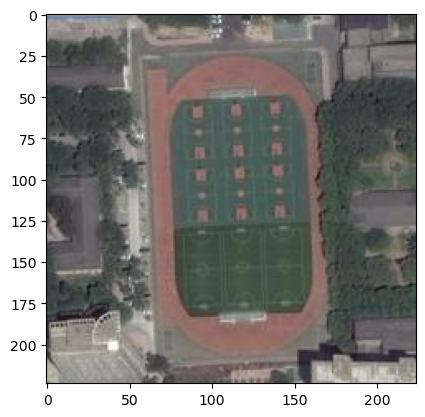

In [ ]:
generate_caption("00623.jpg")

---------------------Actual---------------------
startseq theres lot of bare land near the airport endseq
startseq many white planes were parked at the airport endseq
startseq many white planes were parked at the airport endseq
startseq theres lot of naked land near the airport endseq
startseq there are many bare land near the airport endseq
--------------------Predicted--------------------
many buildings and some green trees are in school


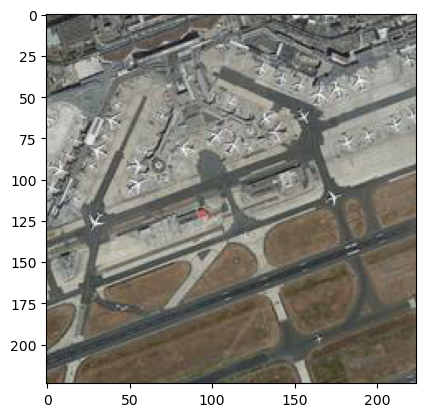

In [ ]:
generate_caption("airport_350.jpg")

---------------------Actual---------------------
startseq truck is driving on bare ground endseq
startseq there was narrow path on the bare earth endseq
startseq there was narrow path on the bare land endseq
startseq truck is driving in the bare land endseq
startseq truck is driving on the bare land endseq
--------------------Predicted--------------------
its piece of yellow desert


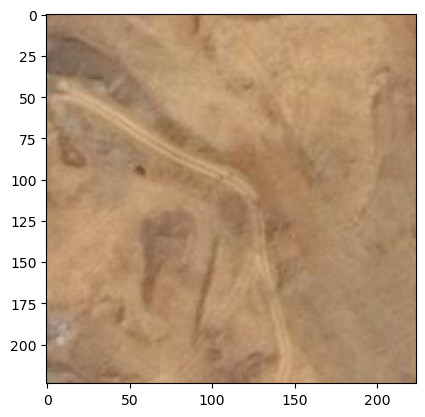

In [ ]:
generate_caption("bareland_59.jpg")

---------------------Actual---------------------
startseq the round area is baseball field endseq
startseq the baseball field is surrounded by grey roof endseq
startseq the baseball field is surrounded by grey roof endseq
startseq the round area is baseball field endseq
startseq the round area is baseball field endseq
--------------------Predicted--------------------
there are some trees around the square


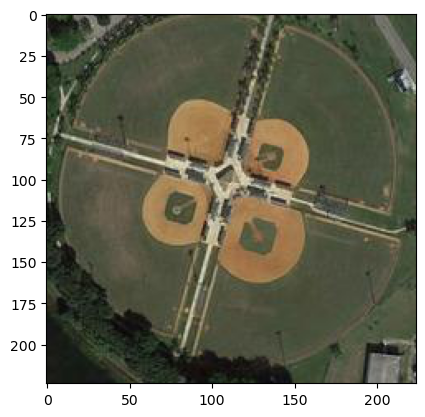

In [ ]:
generate_caption("baseballfield_69.jpg")

---------------------Actual---------------------
startseq theres no plant on this beach endseq
startseq in front of the beach is an ocean endseq
startseq the green water is next to the beach endseq
startseq the water with green color lies beside the beach endseq
startseq there is no plant on this beach endseq
--------------------Predicted--------------------
theres in the middle of the area of


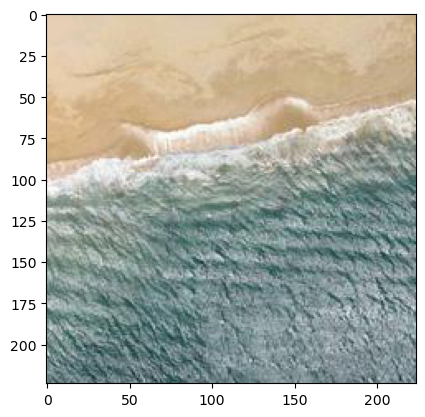

In [ ]:
generate_caption("beach_56.jpg")

---------------------Actual---------------------
startseq trust bridge is built to connect between the two sides of the river endseq
startseq truss bridge is built to connect between the both sides of the river endseq
startseq green bridge connects factory and highway endseq
startseq cable stayed bridge sits over the bridge with two quays on its banks and boats crusing on it endseq
startseq several buildings and some green trees are in two sides of river with bridge over it endseq
--------------------Predicted--------------------
many green trees are around square


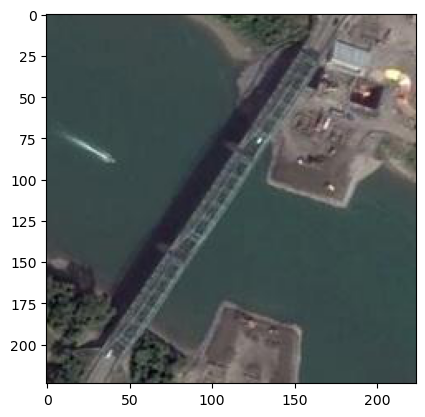

In [ ]:
generate_caption("bridge_53.jpg")

---------------------Actual---------------------
startseq along street are buildings with brick red roofs among which there is church with cross-shaped roof endseq
startseq along street are buildings with brick red roofs among which there is church with cross shaped roof endseq
startseq the earthy yellow cruciform church encompassed by the yellow buildings endseq
startseq we can see cross like church with brown roof sits close to houses endseq
startseq red church near several green trees is near road with many other red buildings endseq
--------------------Predicted--------------------
many green trees are around square


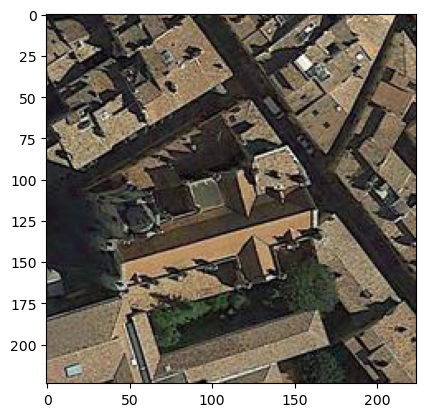

In [ ]:
generate_caption("church_72.jpg")

---------------------Actual---------------------
startseq white advertising with surrounding trees is next to main road and some apartments endseq
startseq between beach and road some buildings are standing with swimming pool endseq
startseq the white commercial with trees surrounding is next to main road and some flats endseq
startseq malls in this commercial area have light colored roofs endseq
startseq many buildings are in commercial area endseq
--------------------Predicted--------------------
many buildings are around square with green trees


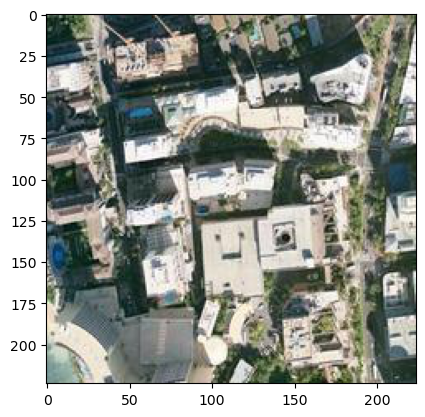

In [ ]:
generate_caption("commercial_67.jpg")

---------------------Actual---------------------
startseq earth is vast green field endseq
startseq theres some bare land near green field endseq
startseq there is some bare land near green field endseq
startseq the earth is vast green field endseq
startseq the land is vast green field endseq
--------------------Predicted--------------------
its piece of yellow desert


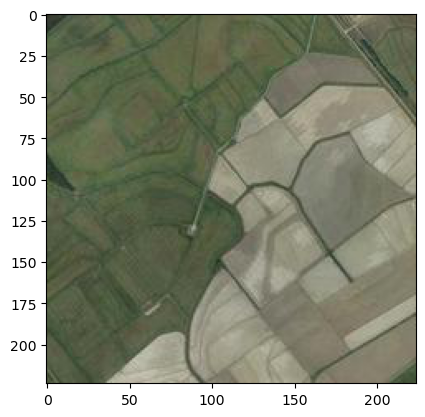

In [ ]:
generate_caption("farmland_37.jpg")

---------------------Actual---------------------
startseq there is herbaceous median and three herbaceous areas with bare trees in the parking lot endseq
startseq there is grassy median and three grassy zones with bare trees in the parking lot endseq
startseq some thwatwise and vertical cars stop ing the parking endseq
startseq only few park spaces are vacant in this parking lot endseq
startseq many cars are parked in parking lot endseq
--------------------Predicted--------------------
lot of trucks parked in the parking lot


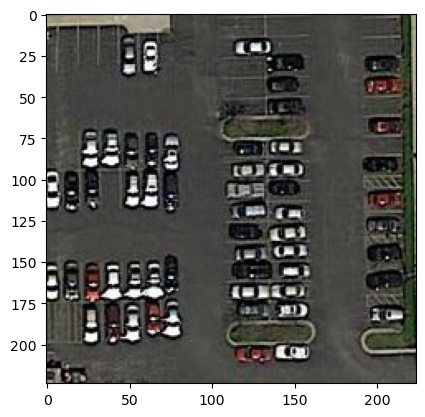

In [ ]:
generate_caption("parking_57.jpg")

In [ ]:
train_generator = data_generator(train_filenames, train_mapping, train_features, tokenizer, max_length, vocab_size, batch_size)
valid_generator = data_generator(valid_filenames, valid_mapping, valid_features, tokenizer, max_length, vocab_size, batch_size)
steps = len(train_filenames) // batch_size
validation_steps = len(valid_filenames) // batch_size

model.fit(train_generator, epochs=25, steps_per_epoch=steps, validation_data=valid_generator,validation_steps=validation_steps,verbose=1)
model.save('./best_vgg16_model_50.h5')
PREDICT_BLEU()

Epoch 1/25
272/272 [==============================] - 86s 314ms/step - loss: 1.3737 - val_loss: 3.1245
Epoch 2/25
272/272 [==============================] - 86s 316ms/step - loss: 1.3404 - val_loss: 3.2917
Epoch 3/25
272/272 [==============================] - 85s 312ms/step - loss: 1.3113 - val_loss: 3.3009
Epoch 4/25
272/272 [==============================] - 85s 313ms/step - loss: 1.2903 - val_loss: 3.3093
Epoch 5/25
272/272 [==============================] - 84s 311ms/step - loss: 1.2694 - val_loss: 3.3230
Epoch 6/25
272/272 [==============================] - 84s 309ms/step - loss: 1.2482 - val_loss: 3.3393
Epoch 7/25
272/272 [==============================] - 84s 310ms/step - loss: 1.2359 - val_loss: 3.2459
Epoch 8/25
272/272 [==============================] - 85s 313ms/step - loss: 1.2235 - val_loss: 3.3620
Epoch 9/25
272/272 [==============================] - 85s 313ms/step - loss: 1.2174 - val_loss: 3.5409
Epoch 10/25
272/272 [==============================] - 85s 313ms/step - l

---------------------Actual---------------------
startseq this is huge playground with basketball courts and tennis courts planned orderly inside endseq
startseq some green trees and some buildings are around playground with six basketball fields in it endseq
startseq playground with basketball fields is surrounded by many green trees and buildings endseq
startseq playground with six basketball fields in it is surrounded by many green trees and many buildings endseq
startseq playground with basketball fields in it is surrounded by many green trees and buildings endseq
--------------------Predicted--------------------
many buildings and green trees are around stadium


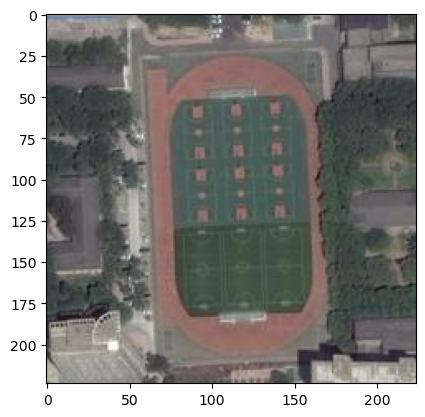

In [ ]:
generate_caption("00623.jpg")

---------------------Actual---------------------
startseq theres lot of bare land near the airport endseq
startseq many white planes were parked at the airport endseq
startseq many white planes were parked at the airport endseq
startseq theres lot of naked land near the airport endseq
startseq there are many bare land near the airport endseq
--------------------Predicted--------------------
many buildings are on two sides of railway station


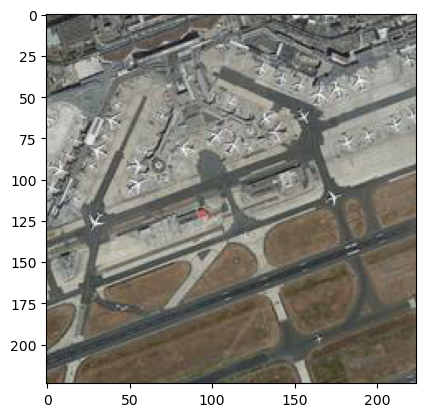

In [ ]:
generate_caption("airport_350.jpg")

---------------------Actual---------------------
startseq truck is driving on bare ground endseq
startseq there was narrow path on the bare earth endseq
startseq there was narrow path on the bare land endseq
startseq truck is driving in the bare land endseq
startseq truck is driving on the bare land endseq
--------------------Predicted--------------------
the bare land


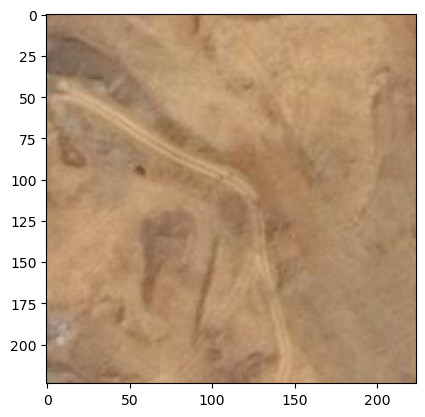

In [ ]:
generate_caption("bareland_59.jpg")

---------------------Actual---------------------
startseq the round area is baseball field endseq
startseq the baseball field is surrounded by grey roof endseq
startseq the baseball field is surrounded by grey roof endseq
startseq the round area is baseball field endseq
startseq the round area is baseball field endseq
--------------------Predicted--------------------
four baseball courts are surrounded by green trees


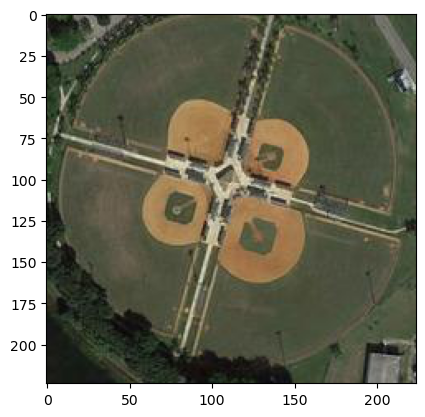

In [ ]:
generate_caption("baseballfield_69.jpg")

---------------------Actual---------------------
startseq theres no plant on this beach endseq
startseq in front of the beach is an ocean endseq
startseq the green water is next to the beach endseq
startseq the water with green color lies beside the beach endseq
startseq there is no plant on this beach endseq
--------------------Predicted--------------------
some trees are planted on the land


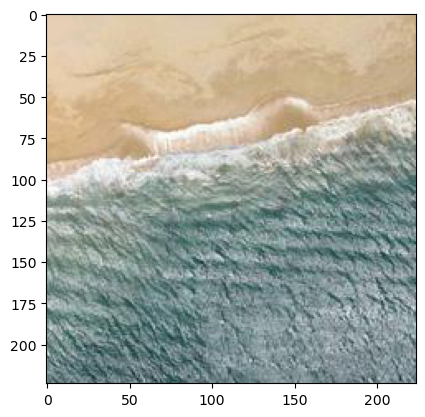

In [ ]:
generate_caption("beach_56.jpg")

---------------------Actual---------------------
startseq trust bridge is built to connect between the two sides of the river endseq
startseq truss bridge is built to connect between the both sides of the river endseq
startseq green bridge connects factory and highway endseq
startseq cable stayed bridge sits over the bridge with two quays on its banks and boats crusing on it endseq
startseq several buildings and some green trees are in two sides of river with bridge over it endseq
--------------------Predicted--------------------
many green trees are around square circle


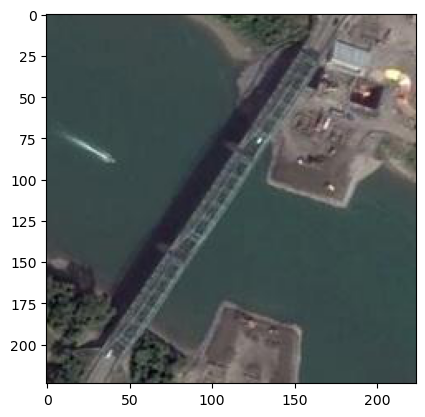

In [ ]:
generate_caption("bridge_53.jpg")

---------------------Actual---------------------
startseq along street are buildings with brick red roofs among which there is church with cross-shaped roof endseq
startseq along street are buildings with brick red roofs among which there is church with cross shaped roof endseq
startseq the earthy yellow cruciform church encompassed by the yellow buildings endseq
startseq we can see cross like church with brown roof sits close to houses endseq
startseq red church near several green trees is near road with many other red buildings endseq
--------------------Predicted--------------------
some green trees are around stadium


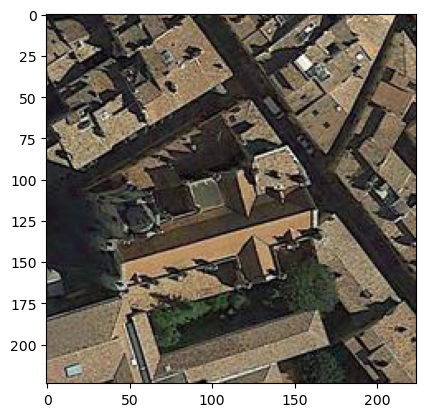

In [ ]:
generate_caption("church_72.jpg")

---------------------Actual---------------------
startseq white advertising with surrounding trees is next to main road and some apartments endseq
startseq between beach and road some buildings are standing with swimming pool endseq
startseq the white commercial with trees surrounding is next to main road and some flats endseq
startseq malls in this commercial area have light colored roofs endseq
startseq many buildings are in commercial area endseq
--------------------Predicted--------------------
many buildings are around square with many green trees


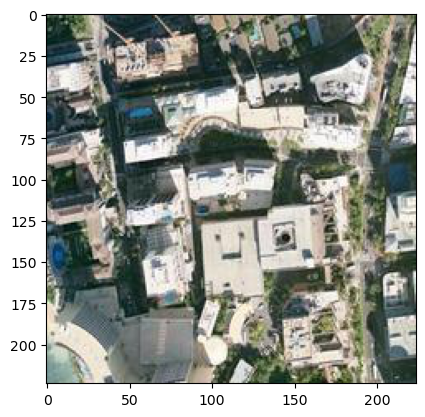

In [ ]:
generate_caption("commercial_67.jpg")

---------------------Actual---------------------
startseq earth is vast green field endseq
startseq theres some bare land near green field endseq
startseq there is some bare land near green field endseq
startseq the earth is vast green field endseq
startseq the land is vast green field endseq
--------------------Predicted--------------------
some trees are on two sides of curved river


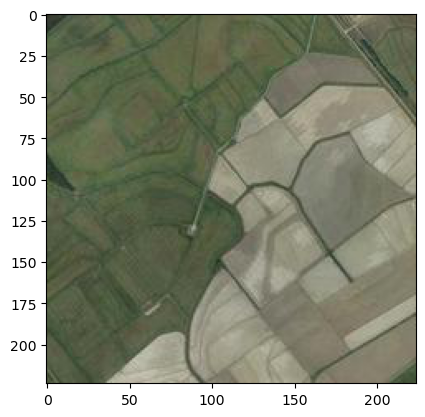

In [ ]:
generate_caption("farmland_37.jpg")

---------------------Actual---------------------
startseq there is herbaceous median and three herbaceous areas with bare trees in the parking lot endseq
startseq there is grassy median and three grassy zones with bare trees in the parking lot endseq
startseq some thwatwise and vertical cars stop ing the parking endseq
startseq only few park spaces are vacant in this parking lot endseq
startseq many cars are parked in parking lot endseq
--------------------Predicted--------------------
many trees are planted around the square


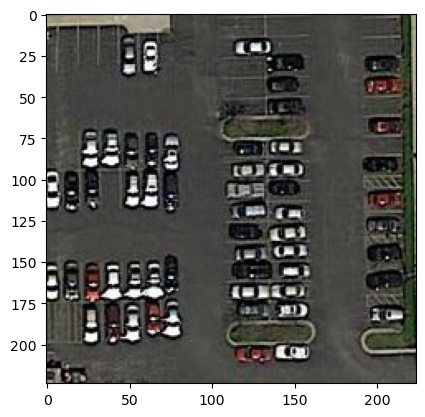

In [ ]:
generate_caption("parking_57.jpg")